In [1]:
import base64
import hashlib
import networkx as nx
import os
import matplotlib.pyplot as plt
import random
from lxml import etree
import pathlib

In [2]:
policy_xsl_path = os.path.join('policy/templates/dds/policy.xsl')
policy_xsd_path = os.path.join('policy/schemas/policy.xsd')
permissions_xsl_path = os.path.join('policy/templates/dds/permissions.xsl')
permissions_xsd_path = os.path.join('policy/schemas/dds/permissions.xsd')

policy_xsl = etree.XSLT(etree.parse(policy_xsl_path))
policy_xsd = etree.XMLSchema(etree.parse(policy_xsd_path))
permissions_xsl = etree.XSLT(etree.parse(permissions_xsl_path))
permissions_xsd = etree.XMLSchema(etree.parse(permissions_xsd_path))

In [3]:
def get_topic(u, v):
    msg = str(u) + str(v)
#     print(msg)
    msg = msg.encode('utf-8')
    digest_bytes = hashlib.sha256(msg).digest()
    digest_base64 = base64.b64encode(digest_bytes)
    return '/' + digest_base64.decode('utf-8')
#     return hashlib.sha256(msg).hexdigest()

In [4]:
def randomMultiDiGraph(g, pos):
    G = nx.MultiDiGraph()
    weights = [0.5, 0.4, 0.1]
    for i in g.nodes():
        for j in g.neighbors(i):
            if not (G.has_edge(i, j) or G.has_edge(j, i)):
                pub = (i, j)
                sub = (j, i)
                choices = [[pub],  [sub],  [pub, sub]]
                directional_edge = random.choices(choices)
                for edge in directional_edge[0]:
                    G.add_edge(*edge, topic=get_topic(*edge))
        G.add_node(i, pos=pos[i])
    return G

In [5]:
def get_xml_policy(G, prefix):    
    policy_element = etree.Element('policy', attrib={'version': '1.0.0'})
    profiles_element = etree.Element("profiles")
    policy_element.append(profiles_element)
    for node in G.nodes:
        profile_attrib = {
            'ns': '/',
            'node': prefix + str(node)[1:-1].replace(', ', '_'),
        }
        profile_element = etree.Element("profile", attrib=profile_attrib)
        profiles_element.append(profile_element)
        
        if G.out_edges(node):
            publish_topics_attrib = {
                'publish': 'ALLOW',
            }
            publish_topics_element = etree.Element("topics", attrib=publish_topics_attrib)
            profile_element.append(publish_topics_element)

            for edge in G.out_edges(node):
                    topic_element = etree.Element("topic")
                    topic_element.text = G.get_edge_data(*edge)[0]['topic']
                    publish_topics_element.append(topic_element)
        
        if G.in_edges(node):
            subscribe_topics_attrib = {
                'subscribe': 'ALLOW',
            }
            subscribe_topics_element = etree.Element("topics", attrib=subscribe_topics_attrib)
            profile_element.append(subscribe_topics_element)
            for edge in G.in_edges(node):
                    topic_element = etree.Element("topic")
                    topic_element.text = G.get_edge_data(*edge)[0]['topic']
                    subscribe_topics_element.append(topic_element)
    policy_xsd.assertValid(policy_element)
    return policy_element

def get_xml_permissions(policy_element):
    _permissions_element = policy_xsl(policy_element)
    permissions_element = permissions_xsl(_permissions_element)
    permissions_xsd.assertValid(permissions_element)
    return permissions_element

In [6]:
def save_permissions(path, permissions_element):
    for grant_element in permissions_element.findall('permissions/grant'):
        dds_element = etree.Element('dds')
        permissions_element = etree.Element("permissions")
        dds_element.append(permissions_element)
        permissions_element.append(grant_element)
        
        name = grant_element.attrib['name']
        permissions_dir = pathlib.Path(path, name)
        permissions_dir.mkdir(parents=True, exist_ok=True)
        permissions_path = permissions_dir.joinpath('permissions.xml')
        
        with open(permissions_path, 'wb') as f:
            f.write(etree.tostring(dds_element, pretty_print=True))

In [7]:
def draw_graph(G):
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G, pos=pos, with_labels = True, node_size=600, font_size=8)

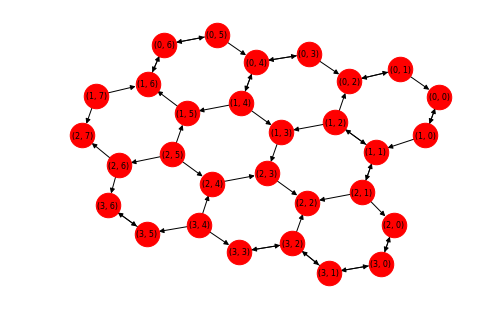

In [8]:
G = nx.hexagonal_lattice_graph(3,3)
pos = nx.layout.kamada_kawai_layout(G)
G = randomMultiDiGraph(G, pos)
draw_graph(G)
plt.show()

In [9]:
policy_element = get_xml_policy(G, 'hex_')
permissions_element = get_xml_permissions(policy_element)
save_permissions('credentials/hexagonal_lattice_graph', permissions_element)
nx.write_gpickle(G, 'credentials/hexagonal_lattice_graph/graph.gpickle')

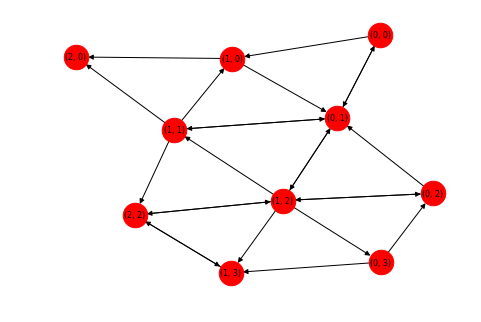

In [10]:
G = nx.triangular_lattice_graph(3,3)
pos = nx.layout.spring_layout(G)
G = randomMultiDiGraph(G, pos)
draw_graph(G)
plt.show()

In [11]:
policy_element = get_xml_policy(G, 'tri_')
permissions_element = get_xml_permissions(policy_element)
save_permissions('credentials/triangular_lattice_graph', permissions_element)
nx.write_gpickle(G, 'credentials/triangular_lattice_graph/graph.gpickle')

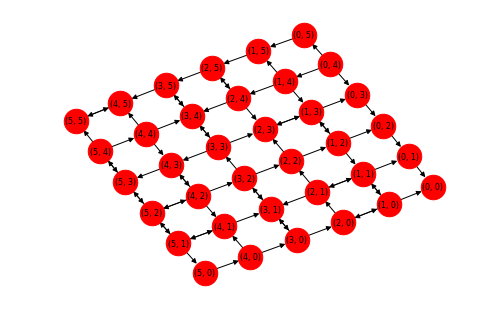

In [12]:
G = nx.grid_2d_graph(6,6)
pos = nx.layout.kamada_kawai_layout(G)
G = randomMultiDiGraph(G, pos)
draw_graph(G)
plt.show()

In [13]:
policy_element = get_xml_policy(G, 'grid_')
permissions_element = get_xml_permissions(policy_element)
save_permissions('credentials/grid_2d_graph', permissions_element)
nx.write_gpickle(G, 'credentials/grid_2d_graph/graph.gpickle')